# 深度学习大作业：使用预训练的神经网络预测人民币面额

## 1.将VGG16卷积基实例化

In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet',
                 include_top = False)

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## 不使用数据增强

## 2.使用预训练的卷积基提取特征

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'RMB'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
#         target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 40)
validation_features, validation_labels = extract_features(validation_dir, 20)
test_features, test_labels = extract_features(test_dir, 20)

Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (40, 8 * 8 * 512))
validation_features = np.reshape(validation_features, (20, 8 * 8 * 512))
test_features = np.reshape(test_features, (20, 8 * 8 * 512))

## 3.定义并训练密集链接分类器

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=8 * 8 * 512))
model.add(layers.Dropout(0.3))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 40 samples, validate on 20 samples
Epoch 1/30
40/40 [==============================] - 1s 22ms/step - loss: 0.9066 - acc: 0.4500 - val_loss: 0.6638 - val_acc: 0.6000
Epoch 2/30
40/40 [==============================] - 1s 18ms/step - loss: 0.6172 - acc: 0.7000 - val_loss: 0.6057 - val_acc: 0.7000
Epoch 3/30
40/40 [==============================] - 1s 21ms/step - loss: 0.4520 - acc: 0.8500 - val_loss: 0.5790 - val_acc: 0.7500
Epoch 4/30
40/40 [==============================] - 1s 22ms/step - loss: 0.3832 - acc: 0.9000 - val_loss: 0.5674 - val_acc: 0.7500
Epoch 5/30
40/40 [==============================] - 1s 20ms/step - loss: 0.3637 - acc: 0.9000 - val_loss: 0.5548 - val_acc: 0.7000
Epoch 6/30
40/40 [==============================] - 1s 20ms/step - loss: 0.3440 - acc: 0.8500 - val_loss: 0.5190 - val_acc: 0.8500
Epoch 7/30
40/40 [==============================] - 1s 22ms/step - loss: 0.3

## 4.作图分析

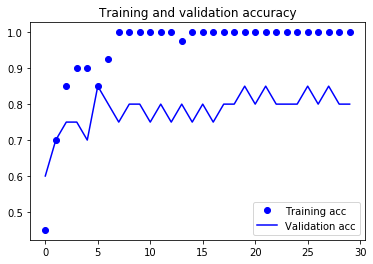

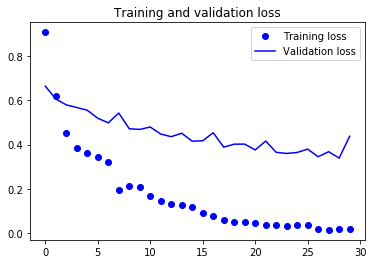

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

不使用数据增强的模型过拟合很快，验证准确率在80%左右

## 数据增强

## 5.在卷积基上添加有个密集连接分类器

In [67]:
conv_base = VGG16(weights='imagenet',
                 include_top = False,
                 input_shape=(150,300,3))

In [68]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [69]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [70]:
# 冻结卷积基
conv_base.trainable = False

In [ ]:
?layers.Flatten

In [71]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


## 6.利用冻结的卷积基端到端的训练模型

In [86]:
from keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

base_dir = 'RMB'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 300),
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 300),
        batch_size=10,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=4, # 40/10=4
      epochs=30,
      validation_data=validation_generator,
      validation_steps=2) # 20/10=2

Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/30
4/4 [==============================] - 10s 3s/step - loss: 0.4983 - acc: 0.7250 - val_loss: 0.5309 - val_acc: 0.8500
Epoch 2/30
4/4 [==============================] - 9s 2s/step - loss: 0.3863 - acc: 0.9500 - val_loss: 0.4963 - val_acc: 0.8500
Epoch 3/30
4/4 [==============================] - 9s 2s/step - loss: 0.4130 - acc: 0.9000 - val_loss: 0.3735 - val_acc: 0.8500
Epoch 4/30
4/4 [==============================] - 9s 2s/step - loss: 0.4684 - acc: 0.8000 - val_loss: 0.4199 - val_acc: 0.8500
Epoch 5/30
4/4 [==============================] - 9s 2s/step - loss: 0.4285 - acc: 0.8250 - val_loss: 0.3742 - val_acc: 0.8500
Epoch 6/30
4/4 [==============================] - 9s 2s/step - loss: 0.4281 - acc: 0.8000 - val_loss: 0.4188 - val_acc: 0.8500
Epoch 7/30
4/4 [==============================] - 9s 2s/step - loss: 0.3745 - acc: 0.9500 - val_loss: 0.3599 - val_acc: 0.8500
Epoch 8/30
4/4 [==============

## 7.作图分析

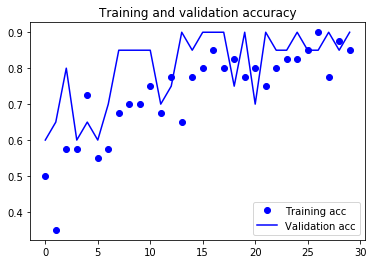

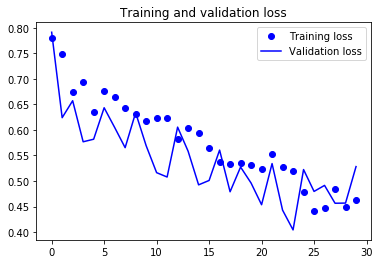

In [73]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

使用数据增强的模型过拟合情况要好一些，验证准确率接近90%

## 8.使用测试集测试模型

In [87]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 300),
        batch_size=10,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=2)
print('test acc:', test_acc)

Found 20 images belonging to 2 classes.
test acc: 0.8999999761581421


## 9.使用模型预测图片

In [25]:
# 保存模型
# model.save('RMB_data_augmentation.h5')

In [55]:
# 导入保存的模型
from keras.models import load_model
# model = load_model('RMB_data_augmentation.h5')

In [75]:
# 读取图片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # mpimg 用于读取图片
test_img = mpimg.imread('test_50.jpg')

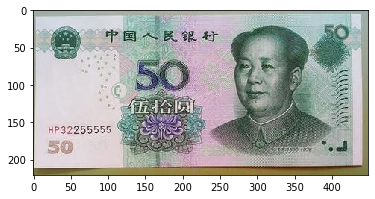

In [76]:
plt.imshow(test_img)
plt.show()

In [77]:
test_img.shape

(221, 449, 3)

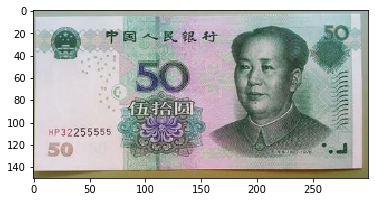

(150, 300, 3)

In [78]:
import cv2
test_img = cv2.resize(test_img,(300,150))
plt.imshow(test_img)
plt.show()
test_img.shape

In [79]:
test_img = test_img.reshape(1,150,300,3)
test_img.shape

(1, 150, 300, 3)

In [80]:
model.predict(test_img)

array([[0.9835865]], dtype=float32)

In [81]:
model.predict_classes(test_img)

array([[1]])

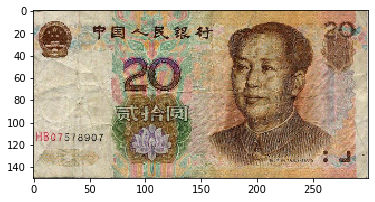

(150, 300, 3)

In [82]:
test_img = mpimg.imread('test_20.jpg')
import cv2
test_img = cv2.resize(test_img,(300,150))
plt.imshow(test_img)
plt.show()
test_img.shape

In [83]:
test_img = test_img.reshape(1,150,300,3)
test_img.shape

(1, 150, 300, 3)

In [84]:
model.predict(test_img)

array([[3.184825e-08]], dtype=float32)

In [85]:
model.predict_classes(test_img)

array([[0]])

## 9.总结
使用数据增强的模型识别出了图像的类别
 - 0 - 20元
 - 1 - 50元